The source for this exercise lecture is in a *Python 2* kernel *Jupyter* notebook.
For more information, see [python.org](https://www.python.org/) and [jupyter.org](http://jupyter.org/).

See [ricopic.one/measurement/notebooks](http://ricopic.one/measurement/notebooks) for the source code notebook.

In [13]:
import matplotlib.pyplot as plt # for plotting
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png','pdf')
import matplotlib.ticker as ticker
from matplotlib2tikz import save as tikz_save
from numpy import * # for all things numeric
from scipy import signal # for square wave signal
save_figures = 1

We observed in the last lecture that significant distortion of a non-sinusoidal periodic function can occur.
Due to the system's significant underdamping and confounded by the input spectral component right on the natural frequency, significant resonance distorted the signal.
But for most measurement systems, we prefer damping ratios nearer unity.
Can these systems also exhibit distortion?
Yes, they can.
Consider the Fourier series of a system with periodic input:
\begin{align}
    u(t) &= 
    \frac{a_0}{2} +
    \sum_{n=1}^\infty C_n \sin(n \omega_1 t + \phi_n).
\end{align}
We derived the output:
\begin{align}
    y(t) &= 
    \frac{a_0}{2} H(j0) +
    \sum_{n=1}^\infty C_n |H(j\omega_n)|\sin(n \omega_1 t + \phi_n + \angle H(j\omega_n)).
\end{align}

Let the system's phase shift $\angle H(j\omega)$ depend *linearly* on $\omega$.
In this case, the fundamental component has shift $\angle H(j\omega_1)$, the second component has shift $2 \angle H(j\omega_1)$, the third $3 \angle H(j\omega_1)$, and each subsequent component $n \angle H(j\omega_1)$.
The $n$th sinusoid in the sum becomes
\begin{align}
    &\sin(n \omega_1 t + n \angle H(j\omega_1) + \phi_n) \\
    = &\sin(n(\omega_1 t + \angle H(j\omega_1)) + \phi_n).
\end{align}
Letting $\theta = t + \angle H(j\omega_1)/\omega_1$, this becomes
\begin{align}
    \sin(n\omega_1 \theta + \phi_n)
\end{align}
Within a time-shift, this is exactly the same as the input!
Therefore, for an input with dominant frequency components below some frequency $\omega_c$, if the magnitude ratio below $\omega_c$ is approximately $1$ and if the measurement system's phase shift below $\omega_c$ is approximately linear in frequency, the output should have the same amplitude and shape as the input, with a time lag.

This is an important result.
Let $\omega_c$ be the *cutoff frequency*, above which the magnitude ratio declines and phase shift becomes significant.
Any periodic input with significant frequency components above $\omega_c$ will exhibit distortion.
Therefore, it is not simply the resonance that distorted the signal from the previous lecture.
We explore this in further detail by applying the square wave to the same system with a single difference: now the damping ratio is $\zeta=0.707$, which has a frequency response that is optimally "flat" and "wide."

First, we generate and plot the input square wave at a few frequencies.
The motivation for multiple frequencies will become clear, later.
The angular frequency of the `n`th harmonic is defined in terms of the square wave period `T`.

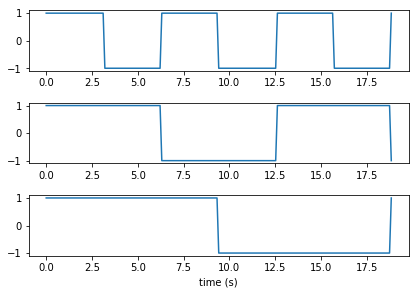

In [8]:
def w(n,T): # angular frequency
    return 2*pi*n/T

# three periods to explore
T1 = 2*pi
T2 = 2*T1
T3 = 3*T1

# plot the square waves
t = linspace(0,6*pi,201)
u_1 = signal.square(w(1,T1)*t)
u_2 = signal.square(w(1,T2)*t)
u_3 = signal.square(w(1,T3)*t)
f,ax=plt.subplots(3,1)
f.tight_layout()
ax=plt.subplot(311)
ax.plot(t,u_1)
ax=plt.subplot(312)
ax.plot(t,u_2)
ax=plt.subplot(313)
ax.plot(t,u_3)
plt.xlabel("time (s)")
plt.show()

The system will be second-order and defined via its magnitude and phase functions, derived previously.
We choose a natural frequency of `5`.
\begin{align}
	|H(j\omega)| &= 
	\frac{1}{
		\sqrt{
			\left(1-(\omega/5)^2\right)^2 +
			(2\zeta\omega/5)^2
		}
	} \quad \text{and} \\
	\angle H(j\omega) &=
	\arctan{
		\frac{-2\zeta \omega/5}{1-(\omega/5)^2}
	}.
\end{align}

In [9]:
def Hm(w,z):
    return 1/sqrt((1-(w/5)**2)**2 + (2*z*w/5)**2)
    
def Hp(w,z):
    return arctan2(-2*z*w/5,1-(w/5)**2)

Let's plot this for two values of $\zeta$.
The results are shown in \autoref{fig:phase_linearity_mag_phase}.

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


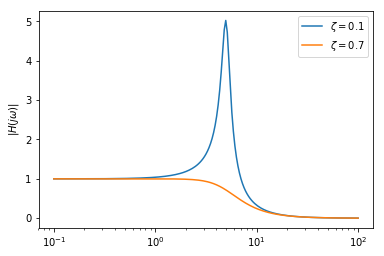

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


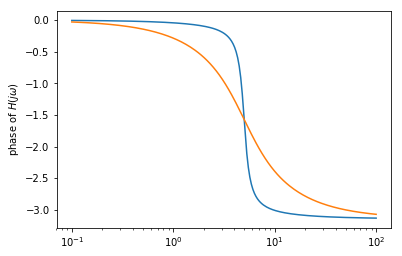

In [19]:
wl = logspace(-1,2,201)
plt.semilogx(wl,Hm(wl,.1),wl,Hm(wl,.7))
plt.ylabel('$|H(j\omega)|$')
plt.legend(['$\zeta = 0.1$','$\zeta = 0.7$'])
if save_figures:
    tikz_save( # save for LaTeX
        'figures/phase_linearity_mag.tex', 
        figureheight='.5\linewidth', 
        figurewidth='1\linewidth'
    )
plt.show()
plt.semilogx(wl,Hp(wl,.1),wl,Hp(wl,.7))
plt.ylabel('phase of $H(j\omega)$')
if save_figures:
    tikz_save( # save for LaTeX
        'figures/phase_linearity_phase.tex', 
        figureheight='.5\linewidth', 
        figurewidth='1\linewidth'
    )
plt.show()

Now, we must write the Fourier series of the output.
Several functions are defined below, culminating in the partial sum `psum` of the series that can be used to plot the response.

In [20]:
def a(n):
    return 0

def b(n):
    return 2/(n*pi)*(1-cos(n*pi))

def c(n,a,b):
    return sqrt(a(n)**2+b(n)**2)

def phi(n,a,b):
    return arctan2(a(n),b(n))

def yn(n,a,b,c,phi,z,T,t):
    return c(n,a,b)*Hm(w(n,T),z)*sin(w(n,T)*t+phi(n,a,b)+Hp(w(n,T),z))

def psum(yn,a,b,c,phi,z,T,t,N):
    s = 0
    for n in range(1,N+1):
        s = s+yn(n,a,b,c,phi,z,T,t)
    return s

Now we turn to three plots: one for each input period `T`. We expect our output will more closely follow the input for larger `T` because fewer significant components will be greater than the cutoff frequency (in this case, the natural frequency `5` rad/s).
We also expect our output to more closely follow the input when the damping is around `0.707` rather than when it is around `0.1` because the resonance effects should be absent ("wide" and "flat").

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


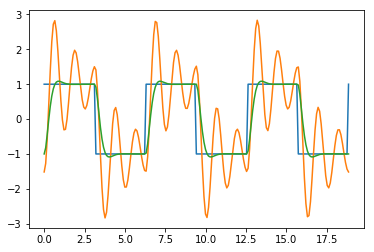

In [21]:
N = 200
znow = [.1,.707]
Tnow = T1
plt.plot(t,u_1)
for zi in znow:
    ps = []
    for ti in t:
        ps.append(psum(yn,a,b,c,phi,zi,Tnow,ti,N))
    plt.plot(t,ps)
if save_figures:
    tikz_save( # save for LaTeX
        'figures/phase_linearity_square_T1.tex', 
        figureheight='.4\linewidth', 
        figurewidth='1\linewidth'
    )
plt.show()

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


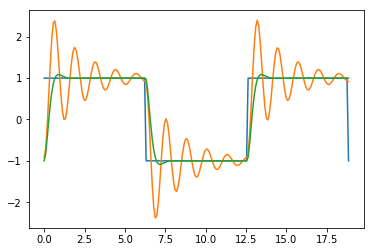

In [22]:
Tnow = T2
plt.plot(t,u_2)
for zi in znow:
    ps = []
    for ti in t:
        ps.append(psum(yn,a,b,c,phi,zi,Tnow,ti,N))
    plt.plot(t,ps)
if save_figures:
    tikz_save( # save for LaTeX
        'figures/phase_linearity_square_T2.tex', 
        figureheight='.4\linewidth', 
        figurewidth='1\linewidth'
    )
plt.show()

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


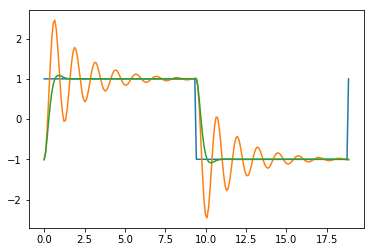

In [23]:
Tnow = T3
plt.plot(t,u_3)
for zi in znow:
    ps = []
    for ti in t:
        ps.append(psum(yn,a,b,c,phi,zi,Tnow,ti,N))
    plt.plot(t,ps)
if save_figures:
    tikz_save( # save for LaTeX
        'figures/phase_linearity_square_T3.tex', 
        figureheight='.4\linewidth', 
        figurewidth='1\linewidth'
    )
plt.show()